# Mini-Challenge 1

Modul: Deep Learning  
Thema: Hyperparameter und Model Tuning  
Student: Si Ben Tran  
Fachexperte: Martin Melchior  
Abgabetermin: Ende FS23   

Ziel:  
Implementiere, trainiere und validiere ein Neuronales Netzwerk Modell für einen
Klassifikationstask mit geeignetem Dataset. Der zu modellierende Task und die dazu
passenden Daten sollen am Anfang der Mini-Challenge individuell vereinbart werden. Dabei
können die Studierenden auch ihre Wünsche einbringen und Task/Datensatz vorschlagen.
Dabei ist aber darauf zu achten, dass der Fokus auf das Training und die Evaluation gelegt
und nicht zu viel Zeit mit Datenbeschaffung, -Analyse und -Vorverarbeitung verbraucht wird.
Der Datensatz sollte auch nicht zu gross sein, um viele verschiedene Modell- und
Parametervarianten evaluieren zu können. Ausserdem sollten nicht zu ausgeklügelte
komplexe Modell-Architekturen untersucht werden. Ein MLP für die Klassifikation allenfalls
mit ein paar CNN-Layern für Feature-Extraktion sollte ausreichen.

Zeitlicher Rahmen:  
Wird beim Schritt 1 verbindlich festgelegt.

Beurteilung:  
Beurteilt wird auf Basis des abgegebenen Notebooks:  
• Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung.  
• Klare, gut-strukturierte Umsetzung.  
• Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut kommentierten Plots und Tabellen.  
• Vernünftiger Umgang mit (Computing-)Ressourcen.  
• Verständliche Präsentation der Ergebnisse.  


---

# Arbeitsschritte

## Schritt 1: Auswahl Task / Datensatz  

**Absprache/Beschluss** mit Fachcoach über Daten/Task.

**1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task
gelernt werden soll.**  

Gedanken: Ich moechte gerne ein CNN-Modell zur Klassifizierung des CIFAR-10-Datensatzes zu trainieren, um ein besseres Verständnis von CNNs zu erlangen und die Hyperparameter mithilfe von Weights & Biases-Integration zu optimieren.

**2. Diskutiere die Idee mit dem Fachcoach.**  

Diskussion: Es wurde mal vorerst vereinbart, am 16.04.23 die Minichallenge 1 abzugeben und die Aufgaben zu erledigen. 


---

## Schritt 2: Daten Kennenlernen
Wie erwähnt, sollte dieser Schritt nicht viel Zeit beanspruchen, da der Datensatz einfach
sein soll!


**1. Mache Dich mit dem Datensatz vertraut, indem Du eine (kurze) explorative Analyse
der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der
Klassen.**


In [2]:
# Libraries Laden

## PyTorch Libraries
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn 
# import torch.nn.functional as F for activation functions
import torch.nn.functional as F

# import pytorch optimizer for training
import torch.optim as optim

# import summary function from torchsummary
from torchsummary import summary

## Data Science Libraries 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## import wandb for logging and tracking
import wandb

# Device Einstellungen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('torch cuda is available:', torch.cuda.is_available())
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    print('No GPU available, using the CPU instead.')

# wandb login 
print("Successfull wandb login: ", wandb.login())

torch cuda is available: True
Using device: cuda
NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 7ben18. Use `wandb login --relogin` to force relogin


Successfull wandb login:  True


In [3]:
# create function for getting cifar10 dataset
def get_dataset(data_dir = './data', dimension_info = True):
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                            download=True, transform=transforms.ToTensor())
    valset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                             download=True, transform=transforms.ToTensor())
    if dimension_info:
        print("Trainingsset: Anzahl Bilder {}, Hoehe {}, Breite {}, Farbkanäle {}".format(trainset.data.shape[0], trainset.data.shape[1], trainset.data.shape[2], trainset.data.shape[3]))
        print("Valset: Anzahl Bilder {} , Hoehe {}, Breite {}, Farbkanäle {}".format(valset.data.shape[0], valset.data.shape[1], valset.data.shape[2], valset.data.shape[3]))

    return trainset, valset

In [4]:
# get dataset
trainset, valset = get_dataset()

Files already downloaded and verified
Files already downloaded and verified
Trainingsset: Anzahl Bilder 50000, Hoehe 32, Breite 32, Farbkanäle 3
Valset: Anzahl Bilder 10000 , Hoehe 32, Breite 32, Farbkanäle 3


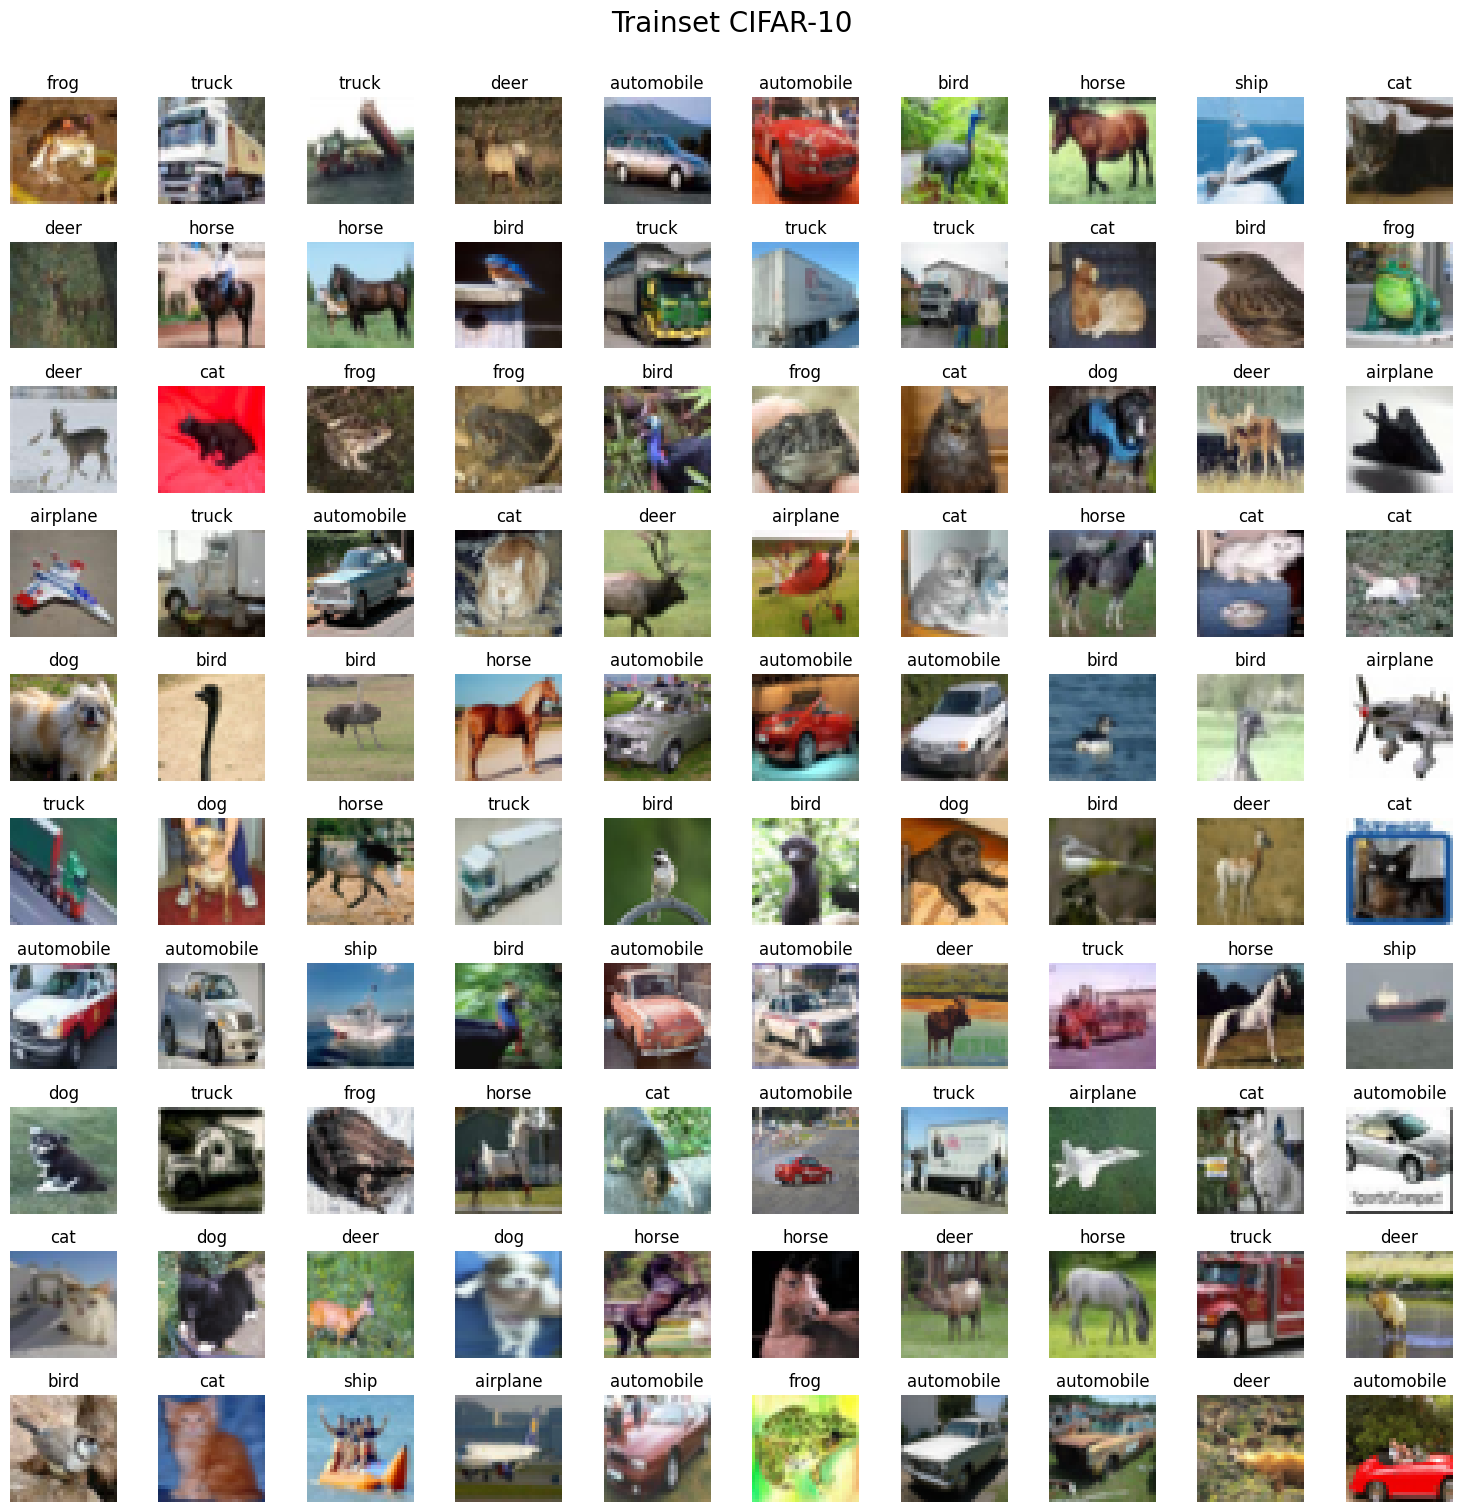

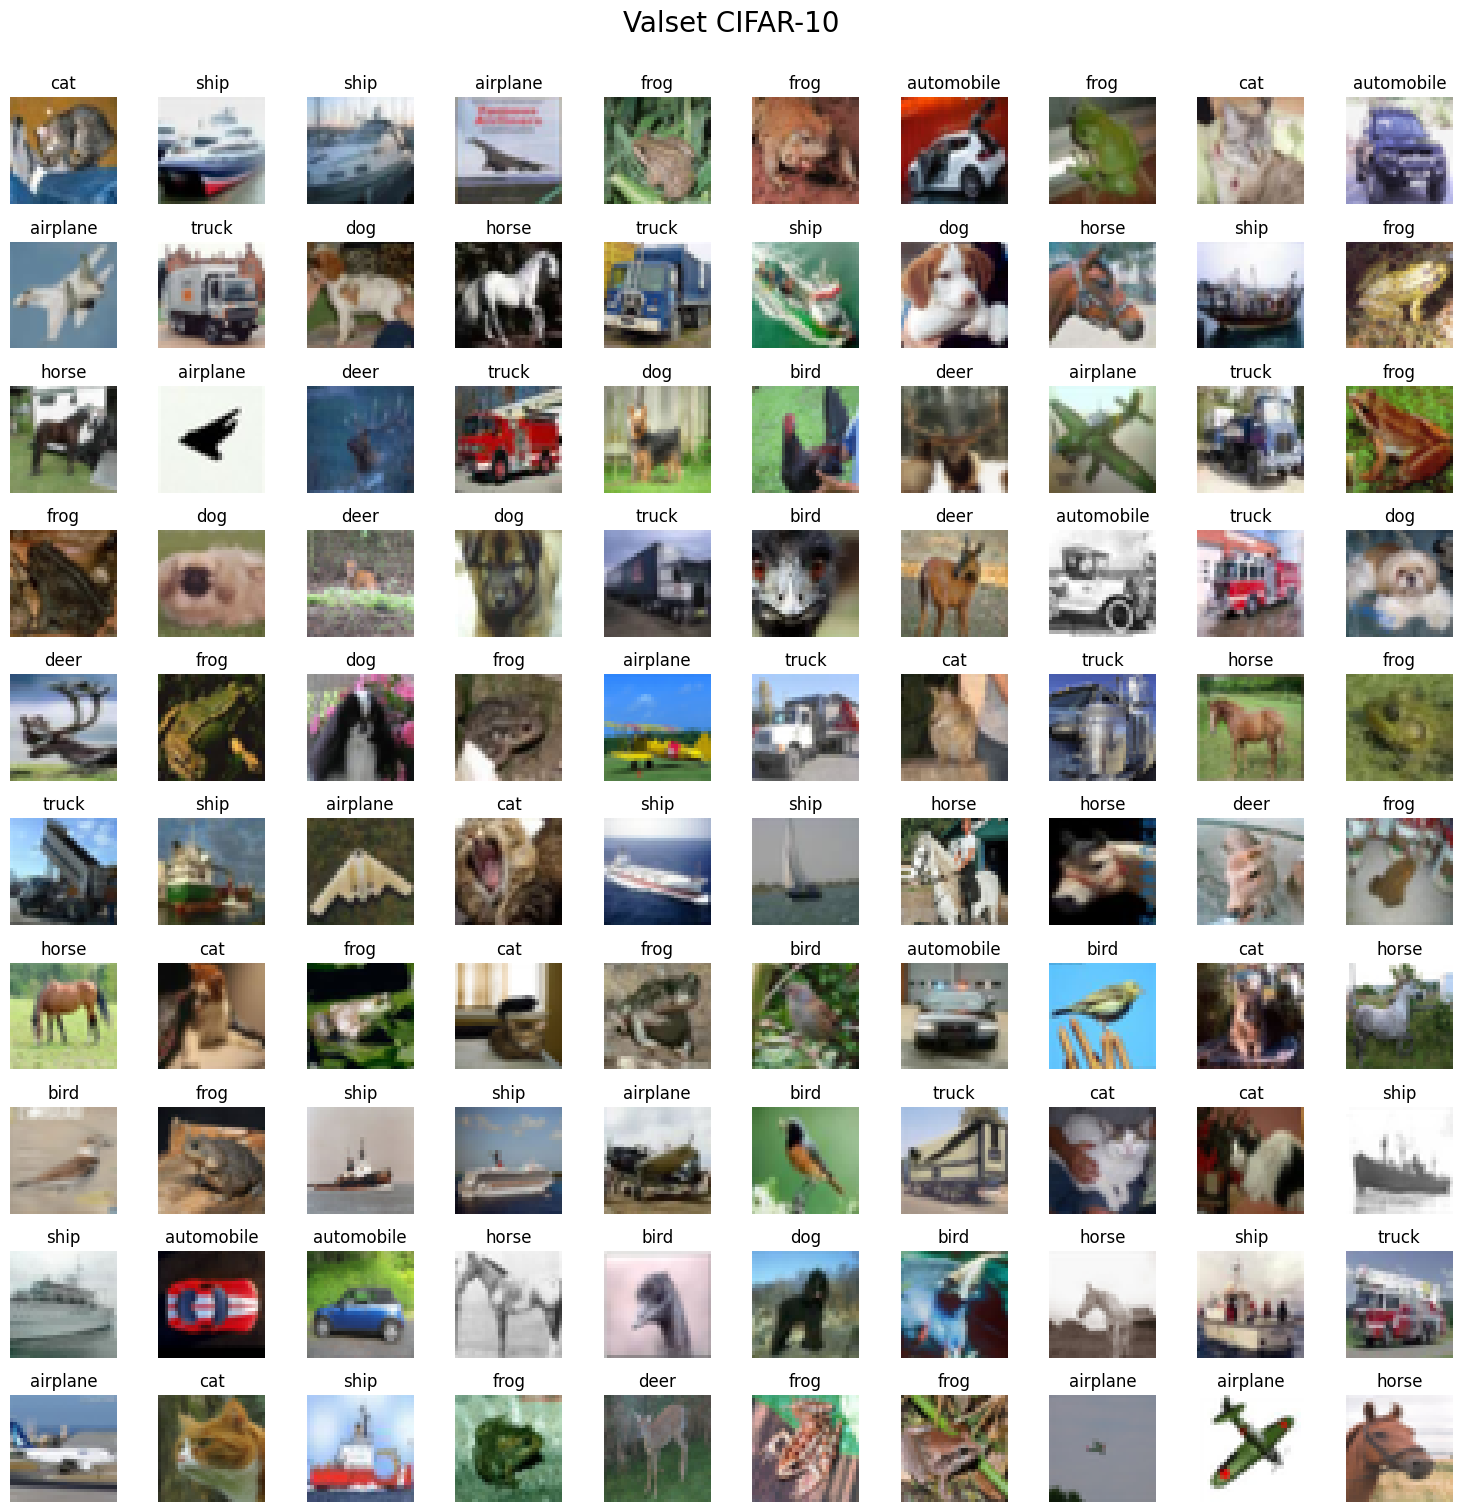

In [5]:
# create a function for plotting 10x10 grid
def plot_10x10_grid(data, title):
    '''
    plotting 10x10 grid of images
    '''
    fig, ax = plt.subplots(10, 10, figsize=(15, 15))
    for i in range(10):
        for j in range(10):
            # plot image 
            ax[i, j].imshow(data.data[i*10+j])
            # add title to each subplot
            ax[i, j].set_title(data.classes[data.targets[i*10+j]])
            # set axis labeling off
            ax[i, j].axis('off')
            # set grid off
            ax[i, j].grid(False)
    # add title and adjust layout
    plt.suptitle(title, fontsize=20, y = 1.005)
    plt.tight_layout()
    plt.show()

# plot testset 10x10 grid
plot_10x10_grid(trainset, 'Trainset CIFAR-10')
plot_10x10_grid(valset, 'Valset CIFAR-10')

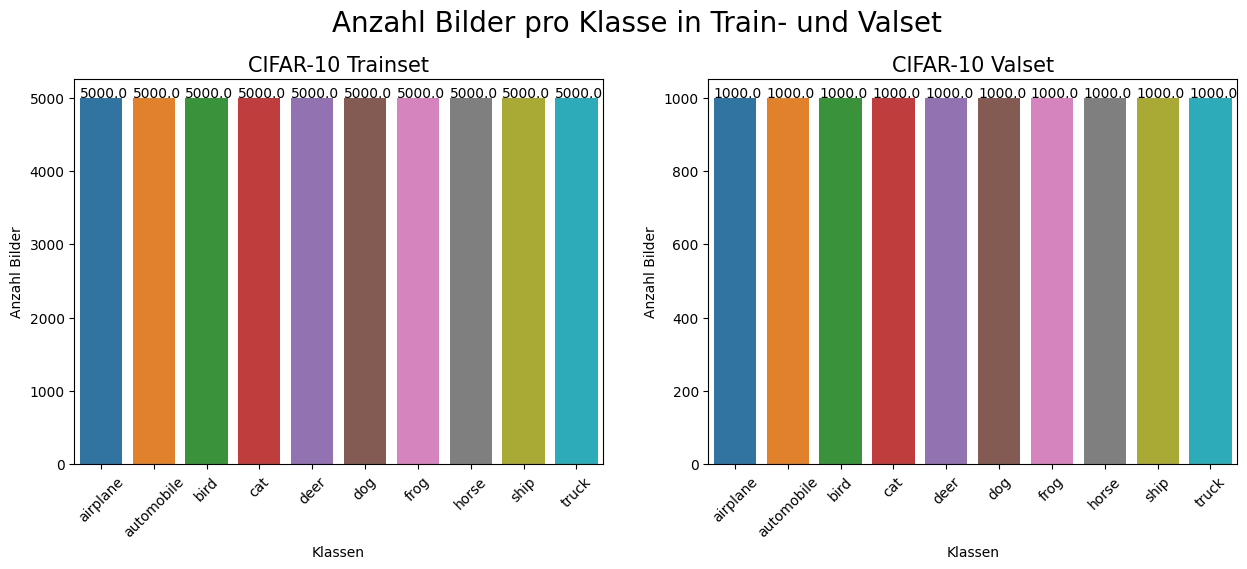

In [6]:
# Visualisierung Anzahl Bilder Pro Klasse  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plot barplot
sns.barplot(x=trainset.classes, y=np.bincount(trainset.targets), ax=ax1)
sns.barplot(x=valset.classes, y=np.bincount(valset.targets), ax=ax2)
# set title and labels
ax1.set_title("CIFAR-10 Trainset", fontsize=15)
ax2.set_title("CIFAR-10 Valset", fontsize=15)
ax1.set_ylabel("Anzahl Bilder", fontsize=10)
ax1.set_xlabel("Klassen", fontsize=10)
ax2.set_ylabel("Anzahl Bilder", fontsize=10)
ax2.set_xlabel("Klassen", fontsize=10)
# rotate xticklabels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
# add suptitle
fig.suptitle("Anzahl Bilder pro Klasse in Train- und Valset", fontsize=20, y = 1.02)
# add number of images to barplot
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x(), p.get_height()))
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height()))
plt.show()


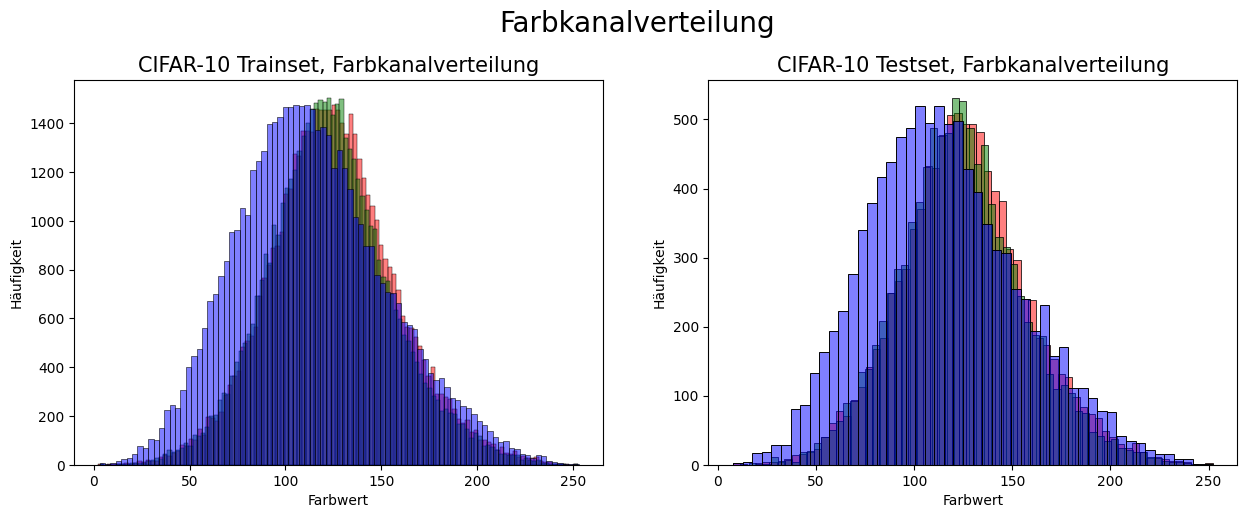

In [7]:
# get the distribution of the colour channels
def get_channel_distribution(data):
    '''
    get the distribution of the colour channels
    '''
    # create empty list for each channel
    r = []
    g = []
    b = []
    # calculate the mean for each 
    for i in range(data.shape[0]):
        r.append(np.mean(data[i, :, :, 0]))
        g.append(np.mean(data[i, :, :, 1]))
        b.append(np.mean(data[i, :, :, 2]))
    return r, g, b

# get the distribution of the colour channels
r_train, g_train, b_train = get_channel_distribution(trainset.data)
r_test, g_test, b_test = get_channel_distribution(valset.data)

# plot the distribution of the colour channels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(r_train, ax=ax1, color='r', alpha = 0.5)
sns.histplot(g_train, ax=ax1, color='g', alpha = 0.5)
sns.histplot(b_train, ax=ax1, color='b', alpha = 0.5)
sns.histplot(r_test, ax=ax2, color='r', alpha = 0.5)
sns.histplot(g_test, ax=ax2, color='g', alpha = 0.5)
sns.histplot(b_test, ax=ax2, color='b', alpha = 0.5)
ax1.set_title("CIFAR-10 Trainset, Farbkanalverteilung", fontsize=15)
ax2.set_title("CIFAR-10 Testset, Farbkanalverteilung", fontsize=15)
ax1.set_ylabel("Häufigkeit", fontsize=10)
ax1.set_xlabel("Farbwert", fontsize=10)
ax2.set_ylabel("Häufigkeit", fontsize=10)
ax2.set_xlabel("Farbwert", fontsize=10)
fig.suptitle("Farbkanalverteilung", fontsize=20, y = 1.02)
plt.show()


**2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten.**

In [8]:
def get_dataloader(normalize=True, batch_size=64, data_dir='./data', num_workers=2, pin_memory=True, drop_last=True):
    '''
    get train and validation dataloaders for a given dataset

    dataset: the name of the dataset to be used, currently supports CIFAR10 and MNIST
    normalize: a boolean indicating whether to apply normalization to the data
    batch_size: the batch size for loading data
    data_dir: the directory where the data will be downloaded and stored
    num_workers: the number of worker processes for loading data
    pin_memory: a boolean indicating whether to pin the memory for faster data transfer
    drop_last: a boolean indicating whether to drop the last incomplete batch when the dataset size is not divisible by the batch size
    '''
    # define transforms
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        transform = transforms.Compose([transforms.ToTensor()])

    # define train and validation datasets
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    valset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

    # define train and validation dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)

    return trainloader, valloader

In [9]:
# get train and validation dataloaders for CIFAR10 dataset with normalization and batch size of 64
trainloader, valloader = get_dataloader(normalize=True, batch_size=5, data_dir='./data', num_workers=2, pin_memory=True, drop_last=True)

# dimension of trainloader and valloader batches
print(f"Trainloader batch size: {trainloader.batch_size}")
print(f"Valloader batch size: {valloader.batch_size}")


Files already downloaded and verified
Files already downloaded and verified
Trainloader batch size: 5
Valloader batch size: 5


---

## Schritt 3: Aufbau Modellierung

**Absprache/Beschluss** mit Fachcoach über die zu untersuchenden Varianten (Schritte 4)

**1. Lege fest, wie (mit welchen Metriken) Du Modelle evaluieren möchtest.
Berücksichtige auch den Fehler in der Schätzung dieser Metriken.**

Als Evaluierungsmetrik verwende ich die Accuracy, da es sich um ein Klassifikationsproblem handelt und die Verteilungen der Klassen ueber den ganzen Datensatz hinweg gleichmaessig verteilt sind, sowohl im Trainingsdatensatz als auch im Testdatensatz.

Die accuracy berechnet sich wie folgt:

$$
\text{accuracy} = \frac{\text{Anzahl korrekt klassifiziert}}{\text{Anzahl aller Beispiele}}
$$

Als Loss Funktion nutzen wir die Cross-Entropy Loss, da es sich um ein multiple Klassifikationsproblem handelt. Die Cross-Entropy Loss berechnet sich wie folgt:

$$
\text{Cross-Entropy Loss} = -\sum_{i=1}^{n} \sum_{j=1}^{m} y_{ij} \log(\hat{y}_{ij})
$$


Wir erstellen verschiedene Modelle und Untersuchung dann das beste Modell.
Folgend werden die Modelle aufgelistet und beschrieben:  

Modell 1: Multi-Layer Perceptron (MLP) mit 2 Hidden Layers und der Aktivierungsfunktion ReLU.

---


**2. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu
evaluieren.**

Empfehlenswert ist die Verwendung einer geeigneten MLOps Plattform (z.B. [W&B](https://wandb.ai/site))

Hier werden einige wichtige Begriffe definiert bevor wir mit der Implementierung des Modells beginnnen:

**Batch Size**   
Die Batch Size definiert die Anzahl Bilder, die gleichzeitig in das Modell gegeben werden. 
Bsp. hat unser Cifar10 Datensatz 50000 Trainingsbilder, eine batchsize = 4 bedeutet, dass wir 4 Bilder gleichzeitig in das Modell geben und gesammthaft 12500 batches haben. (50000/4 = 12500)

**Epoche**  
Eine Epoche ist ein Durchlauf durch den gesamten Trainingsdatensatz. Bsp. hat unser Cifar10 Datensatz 50000 Trainingsbilder, eine batchsize = 4 bedeutet, dass wir 4 Bilder gleichzeitig in das Modell geben und gesammthaft 12500 batches haben. (50000/4 = 12500). Wenn wir nun 10 Epochen trainieren, dann haben wir 12500 * 10 = 125000 Bilder trainiert.

### Multi Layer Perceptron

In [10]:
class MLP_1(nn.Module):
    '''
    Multi Layer Perceptron 4 Layers
    '''
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(32*32*3, 256)
        # first hidden layer
        self.fc2 = nn.Linear(256, 128)
        # second hidden layer
        self.fc3 = nn.Linear(128, 64)
        # output layer
        self.fc4 = nn.Linear(64, 10)

    
    def forward(self, x):
        # flatten input
        x = x.view(x.size(0), -1)
        # input layer
        x = self.fc1(x)
        # relu activation
        x = F.relu(x)
        # first hidden layer
        x = self.fc2(x)
        # relu activation
        x = F.relu(x)
        # second hidden layer
        x = self.fc3(x)
        # relu activation
        x = F.relu(x)
        # output layer
        x = self.fc4(x)
        return x
    
# create mlp model with 4 layers
model_mlp_1 = MLP_1().to(device)

# print model architecture
print("MLP with 4 Layers")
summary(model_mlp_1, (3, 32, 32))

class MLP_2(nn.Module):
    '''
    Multi Layer Perceptron with 6 Layers
    '''
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(32*32*3, 512)
        # first hidden layer
        self.fc2 = nn.Linear(512, 256)
        # second hidden layer
        self.fc3 = nn.Linear(256, 128)
        # third hidden layer
        self.fc4 = nn.Linear(128, 64)
        # fourth hidden layer
        self.fc5 = nn.Linear(64, 32)
        # output layer
        self.fc6 = nn.Linear(32, 10)
    
    def forward(self, x):
        # flatten input
        x = x.view(x.size(0), -1)
        # input layer
        x = self.fc1(x)
        # relu activation
        x = F.relu(x)
        # first hidden layer
        x = self.fc2(x)
        # relu activation
        x = F.relu(x)
        # second hidden layer
        x = self.fc3(x)
        # relu activation
        x = F.relu(x)
        # third hidden layer
        x = self.fc4(x)
        # relu activation
        x = F.relu(x)
        # fourth hidden layer
        x = self.fc5(x)
        # relu activation
        x = F.relu(x)
        # output layer
        x = self.fc6(x)
        return x
    
# crete mlp model with 6 layers
model_mlp_2 = MLP_2().to(device)

# print model architecture
print("MLP with 6 Layers")
summary(model_mlp_2, (3, 32, 32))


MLP with 4 Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 10]             650
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 3.16
Estimated Total Size (MB): 3.18
----------------------------------------------------------------
MLP with 6 Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
            Linear-2                  [-1, 256]         131,328
     

### Convuliutional Neural Network

In [19]:
class CNN_1(nn.Module):
    '''
    Convolutional Neural Network with 2 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, 16*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x

# creating model objects and get the number of parameters
model_cnn_1 = CNN_1().to(device)

# print the model architecture
print("CNN with 2 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_1, (3, 32, 32))

class CNN_2(nn.Module):
    '''
    Convolutional Neural Network with 3 Convolutional Layers and 3 Fully Connected Layers
    '''
    def __init__(self):
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=3)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 max pooling
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=3)
        # first fully connected layer
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=120)
        # second fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # third fully connected layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        ## first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        ## second convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        ## third convolutional layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        ## flatten
        x = x.view(-1, 32*5*5)
        ## first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        ## second fully connected layer
        x = self.fc2(x)
        x = F.relu(x)
        ## third fully connected layer
        x = self.fc3(x)
        return x
    
# creating model objects and get the number of parameters
model_cnn_2 = CNN_2().to(device)

# print the model architecture
print("CNN with 3 Convolutional Layers and 3 Fully Connected Layers")
summary(model_cnn_2, (3, 32, 32))

CNN with 2 Convolutional Layers and 3 Fully Connected Layers
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
CNN with 3 Convolutional Layers and 3 Fully Con

### Modell Training 

In [20]:
# creating a train function for training the model, parameters are: criterion, optimzer, model and dataloader 
def train_modell(model, dataloader, criterion, optimizer, num_epochs=1, verbose=False):
    '''
    This function trains a given model for a given number of epochs and returns the loss and accuracy for each epoch

    model: example: model_cnn_1
    dataloader: trainloader or valloader
    criterion: nn.CrossEntropyLoss()
    optimzer: optim.SGD(model.parameters(), lr = )
    '''
    num_of_total_batches = len(dataloader)
    num_of_total_samples = len(dataloader.dataset)
    epoch_loss = 0
    epoch_correct_predicted = 0

    # iteriere durch alle batches im dataloader
    for batch_index, (images, labels) in enumerate(dataloader):

        # images has dimension [batch_size, colour channel, width, height]
        # labels is a tensor with (list) with the class number

        images = images.to(device)
        labels = labels.to(device)

        # Forward Propagation
        labels_predict = model(images)

        # calculate the loss based on criterion
        loss = criterion(labels_predict, labels)

        # Backward Propagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate metric loss and accuracy
        epoch_loss = epoch_loss + loss
        epoch_correct_predicted = epoch_correct_predicted + (labels_predict.argmax(axis=1) == labels).type(torch.float).sum().item()
    
    # calculate the average loss and accuracy for the epoch
    epoch_avg_loss = epoch_loss / num_of_total_batches
    epoch_accuracy = epoch_correct_predicted / num_of_total_samples

    if verbose:
        print(f"Train Loss: {epoch_avg_loss}, Train Accuracy: {epoch_accuracy}")
        
    return epoch_avg_loss, epoch_accuracy
    
# create a test function for testing the model, parameters are: criterion, model and dataloader
def test_model(model, dataloader, criterion, verbose=False):
    '''
    This function tests a given model and returns the loss and accuracy 

    model: example: model_cnn_1
    dataloader: trainloader or valloader
    criterion: nn.CrossEntropyLoss()
    '''

    num_of_total_batches = len(dataloader)
    num_of_total_samples = len(dataloader.dataset)
    epoch_loss = 0
    epoch_correct_predicted = 0

    # iteriere durch alle batches im dataloader
    for batch_index, (images, labels) in enumerate(dataloader):

        # images has dimension [batch_size, colour channel, width, height]
        # labels is a tensor with (list) with the class number

        images = images.to(device)
        labels = labels.to(device)

        # Forward Propagation
        labels_predict = model(images)

        # calculate the loss based on criterion
        loss = criterion(labels_predict, labels)

        # calculate metric loss and accuracy
        epoch_loss = epoch_loss + loss
        epoch_correct_predicted = epoch_correct_predicted + (labels_predict.argmax(axis=1) == labels).type(torch.float).sum().item()

    # calculate the average loss and accuracy for the epoch
    epoch_avg_loss = epoch_loss / num_of_total_batches
    epoch_accuracy = epoch_correct_predicted / num_of_total_samples

    if verbose:
        print(f"Validation Loss: {epoch_avg_loss}, Validation Accuracy: {epoch_accuracy}")

    return epoch_avg_loss, epoch_accuracy


In [22]:
# first test of the functions
SGD_optimizer = optim.SGD(model_cnn_1.parameters(), lr = 0.01)
criterion_crossentropy = nn.CrossEntropyLoss()

train_modell(model_mlp_2, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer, verbose=True)
test_model(model_mlp_2, valloader, criterion=criterion_crossentropy, verbose=True)

Train Loss: 2.3071234226226807, Train Accuracy: 0.10002
Validation Loss: 2.3071250915527344, Validation Accuracy: 0.1


(tensor(2.3071, device='cuda:0', grad_fn=<DivBackward0>), 0.1)

### Trainieren von Modellen

**3. Teste Modelle und Trainingsfunktionalität, indem Du nur mit einem einzigen Sample
oder einem Batch trainierst. Damit bekommst Du zwar Overfitting, aber auch einen
guten Test, der zeigt dass Information aus den Daten aufgenommen werden kann.**

In [24]:
# define sweep configuration
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.001, 0.01]
        },
        'batch_size': {
            'values': [1]
        },
        'num_epochs': {
            'values': [10, 20]
        },
        'model': {
            'values': ['MLP_1', 'MLP_2', 'CNN_1', 'CNN_2', ]
        }
    }
}

# create a sweep
sweep_id = wandb.sweep(sweep_config, project="del-mc1")

# define the train function for wandb
def wandb_train():
    # initialize a new wandb run
    wandb.init()

    # get the hyperparameters from wandb
    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    num_epochs = wandb.config.num_epochs
    models = wandb.config.model
    
    if models == "MLP_1":
        model = MLP_1().to(device)
    elif models == "MLP_2":
        model = MLP_2().to(device)
    elif models == "CNN_1":
        model = CNN_1().to(device)
    elif models == "CNN_2":
        model = CNN_2().to(device)
        
    # create model
    #model = MLP_1().to(device)

    # create optimizer
    SGD_optimizer = optim.SGD(model.parameters(), lr = lr)
    # create criterion
    criterion_crossentropy = nn.CrossEntropyLoss()

    # get dataloader
    trainloader, valloader = get_dataloader(batch_size=batch_size)

    for epoch in range(num_epochs):
        # train model
        train_loss, train_acc = train_modell(model, trainloader, criterion=criterion_crossentropy, optimizer=SGD_optimizer)
        # test model
        val_loss, val_acc = test_model(model, valloader, criterion=criterion_crossentropy)

        # log metrics to wandb
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": val_acc, "epoch": epoch + 1})

# run the sweep
wandb.agent(sweep_id, function=wandb_train)
wandb.finish()

Create sweep with ID: p9g5xcsq
Sweep URL: https://wandb.ai/7ben18/del-mc1/sweeps/p9g5xcsq


wandb: Agent Starting Run: tky0e5q5 with config:
wandb: 	batch_size: 1
wandb: 	lr: 0.001
wandb: 	model: MLP_1
wandb: 	num_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Files already downloaded and verified
Files already downloaded and verified


---

## Schritt 4: Evaluation

Bei der Evaluation ist darauf zu achten, dass das Vorgehen stets möglichst reflektiert
erfolgt und versucht wird, die Ergebnisse zu interpretieren. Am Schluss soll auch ein
Fazit gezogen werden, darüber welche Variante am besten funktioniert.

### 1. Training mit SGD, ohne REG, ohne BN:  
Untersuche verschiedene Modelle unterschiedlicher Komplexität, welche geeignet
sein könnten, um das Klassifikationsproblem zu lösen. Verwende Stochastic Gradient
Descent - ohne Beschleunigung, ohne Regularisierung (REG) und ohne Batchnorm
(BN). Überlege Dir für jeden Fall, wie die Gewichte initialisiert werden sollen.

In [ ]:
# CODE

**a. Für jedes Modell mit gegebener Anzahl Layer und Units pro Layer führe ein
sorgfältiges Hyper-Parameter-Tuning durch (Lernrate, Batch-Grösse). Achte
stets darauf, dass das Training stabil läuft. Merke Dir bei jedem Training, den
Loss, die Performance Metrik(en) inkl. Schätzfehler, die verwendete Anzahl
Epochen, Lernrate und Batch-Grösse.**

In [ ]:
# CODE

**b. Variiere die Anzahl Layer und Anzahl Units pro Layer, um eine möglichst gute
Performance zu erreichen. Falls auch CNNs (ohne Transfer-Learning)
verwendet werden variiere auch Anzahl Filter, Kernel-Grösse, Stride, Padding.**

In [ ]:
# CODE

**c. Fasse die Ergebnisse zusammen in einem geeigneten Plot, bilde eine
Synthese und folgere, welche Modell-Komplexität Dir am sinnvollsten
erscheint.**

In [ ]:
# CODE

---

### 2. Nutzen der Regularisierung

Ziehe nun verschiedene Regularisierungsmethoden bei den MLP Layern in Betracht:

**a. L1/L2 Weight Penalty**

In [ ]:
# CODE

**b. Dropout**

In [ ]:
# CODE

Evaluiere den Nutzen der Regularisierung, auch unter Berücksichtigung
verschiedener Regularisierungsstärken.
Beschreibe auch kurz, was allgemein das Ziel von Regularisierungsmethoden ist
(Regularisierung im Allgemeinen, sowie auch Idee der einzelnen Methoden).
Inwiefern wird dieses Ziel im gegebenen Fall erreicht?

In [ ]:
# CODE

---

### 3. Nutzen von Batchnorm BN (ohne REG, mit SGD)

Evaluiere, ob Batchnorm etwas bringt. Beschreibe kurz, was die Idee von BN ist,
wozu es helfen soll.

In [ ]:
# CODE

---

### 4. Nutzen von Adam (ohne BN, ohne / mit REG)

Evaluiere, ob Du mit Adam bessere Resultate erzielen kannst.

In [ ]:
# CODE

---

## Schritt 5: Präsentation, Bericht

1. Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse.
Q&A (~10min): Klärung von Verständnisfragen zu Stochastic Gradient Descent,
Parameter Tuning, Regularisierung, Batchnorm und Optimizers.

2. Bericht in Form eines (!) gut dokumentierten, übersichtlichen Jupyter Notebooks.
Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen).

---